In [1]:
import numpy as np
import pandas as pd
import datatable as dt

from lightgbm import LGBMClassifier
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import gc
import janestreet
import seaborn as sns
import warnings
import os
import sys
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
def AddRemoveColsNewColumns(train):
    # Columns dropped her is hard coded for testing, I picked these columns using EDA insights,
    train.drop(["feature_129","feature_78","feature_102","feature_90","feature_114","feature_78","feature_74","feature_92","feature_80","feature_104","feature_116","feature_125","feature_99","feature_93","feature_117","feature_75","feature_81","feature_3","feature_45","feature_4","feature_109"], axis = 1, inplace = True) 
    train.drop(["date","weight","resp_1","resp_2","resp_3","resp_4"], axis = 1, inplace = True) 
    #drop null over 10% and no relation to resp fields
    nulls = train.isnull().sum()
    nulls_list = list(nulls[nulls >(0.1 * len(train))].index)
    train.drop(columns=nulls_list,inplace=True)
    return train

In [3]:
def DoPCA(train):
    return train

In [4]:
def DoTransformation(train):
    # write code here to do any transformations and returned the transformed 
    # Remove outliers
    # Hard code her just to test code
    train.fillna(train.mean())
    features = train.columns.tolist()
    return train, features

In [5]:
def print_score(pred, y_test):
    print('accuracy: {:.4}'.format(accuracy_score(pred, y_test)))
    print('precision: {:.4}'.format(precision_score(pred, y_test)))
    print('recall: {:.4}'.format(recall_score(pred, y_test)))
    print('f1: {:.4}'.format(f1_score(pred, y_test)))
    print('auc: {:.4}'.format(roc_auc_score(pred, y_test)))

In [6]:
def reduce_memory_usage(df):
    
    start_memory = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe is {start_memory} MB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            
            else:
#                 reducing float16 for calculating numpy.nanmean
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    pass
        else:
            df[col] = df[col].astype('category')
    
    end_memory = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe after reduction {end_memory} MB")
    print(f"Reduced by {100 * (start_memory - end_memory) / start_memory} % ")
    return df

def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

In [7]:
def initalise():
    # Reduce the memory
    train = pd.read_csv("/kaggle/input/jane-street-market-prediction/train.csv")
    train = reduce_memory_usage(train)

    # Create the action Column
    train['action']=0
    train.loc[train['resp']>0.0,'action']=1
    train_df = train[train['date']>85]

    # Add new columns & do transformation
    train = AddRemoveColsNewColumns(train)
    train = DoPCA (train)
    train,features = DoTransformation (train)
    return train, features



In [13]:
def GetFeatureImportance (train):
# Remove the first 85 days data as it was quite volitaile
 

    # set the action as target
    train_target = train['action']
    lgb_params = {
        'n_estimators': 1000,
        'learning_rate': 0.05,
        'max_depth': -1,
        'num_leaves': 300,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_lambda': 0.3,
        'reg_alpha': 0.3
    }

    lgb_clf = LGBMClassifier(n_jobs=-1)
    lgb_clf.fit(train, train_target)
    ftr_importances_values = lgb_clf.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=train.columns)
    ftr_top30 = ftr_importances.sort_values(ascending=False)[:30]

    plt.figure(figsize=(12,8))
    plt.title('Feature importances top 30')
    sns.barplot(x=ftr_top30, y=ftr_top30.index)
    plt.show()
    del train
    gc.collect()
    return lgb_clf

In [9]:
def Kaggle_Prediction (model,features):
    env = janestreet.make_env() # initialize the environment 
    iter_test = env.iter_test() # an iterator which loops over the test set

    for (test_df, sample_prediction_df) in iter_test: 
        sample_prediction_df.action = model.predict(test_df[features])
        env.predict(sample_prediction_df)

In [10]:
train,features = initalise()
model=GetFeatureImportance (train)
Kaggle_Prediction (model,features)

Memory usage of dataframe is 2516.843978881836 MB
Memory usage of dataframe after reduction 1247.0233011245728 MB
Reduced by 50.45289610369131 % 


NameError: name 'train_df' is not defined

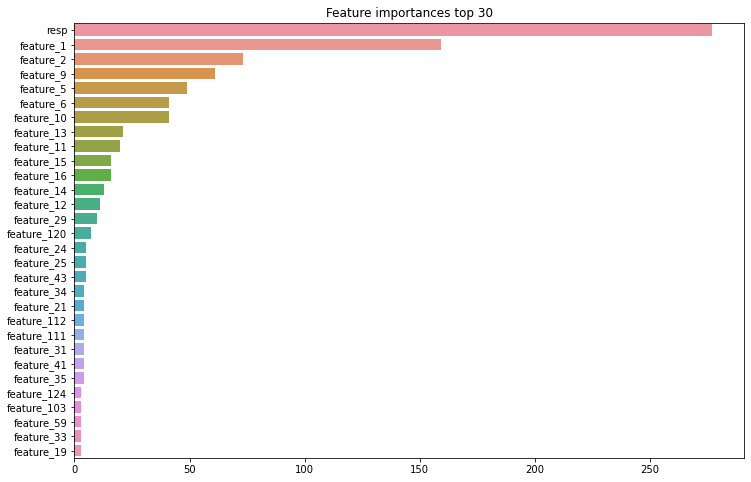

KeyError: "['ts_id', 'action', 'resp'] not in index"

In [14]:
model=GetFeatureImportance (train)
Kaggle_Prediction (model,features)